In [3]:
from matplotlib import pyplot as plt
from matplotlib.dates import DateFormatter
import numpy as np
import xarray as xr
import pandas as pd
import scipy
from datetime import datetime, timedelta
import time
import seaborn
import matplotlib.dates as mdates
import bottleneck as bn
import PyCO2SYS as pyco2
import gsw
import math
import netCDF4 as nc
import requests

from importlib import reload
import warnings
warnings.filterwarnings('ignore')

# function to retrieve Hydrocat data
# %cd phyto
%run PLT.py


# Set up API for Google Sheets

In [4]:
#The scope is always look like this so we did not need to change anything
import gspread
from df2gspread import df2gspread as d2g
from oauth2client.service_account import ServiceAccountCredentials

scope = [
   'https://spreadsheets.google.com/feeds',
         'https://www.googleapis.com/auth/drive']
#Name of our Service Account Key
google_key_file = 'servicecredentials.json'
credentials = ServiceAccountCredentials.from_json_keyfile_name(google_key_file, scope)
gc = gspread.authorize(credentials)

# Get Hydrocat data for Jamestown (620) and Greenwich Bay (720)

In [5]:
df620 = PLT.get_hydrocat('2021-11-01', '2023-05-05', 'PLT')
df720 = PLT.get_hydrocat('2021-11-01', '2023-05-05', 'GB')

In [6]:
df620

,TmStamp,hydrocatStart,hydrocatTemperature,hydrocatConductivity,hydrocatDissOxygen,hydrocatSalinity,hydrocatFluorescence,hydrocatTurbidity,hydrocatPH,DateTime,pH total
0,2021-11-15T12:11:25.400Z,None,12.7368,35.2103,7.975,29.7786,1.274,0.607,7.98,2021-11-15 07:11:25.400000,7.861479
1,2021-11-15T12:26:15.000Z,None,12.6987,35.1439,8.047,29.7463,1.303,0.610,7.99,2021-11-15 07:26:15,7.871503
2,2021-11-15T12:41:15.000Z,None,12.6967,35.1324,8.057,29.7371,1.351,0.613,7.99,2021-11-15 07:41:15,7.871493
3,2021-11-15T12:56:15.000Z,None,12.6971,35.1286,8.052,29.7332,1.459,0.611,7.99,2021-11-15 07:56:15,7.871487
4,2021-11-15T13:11:15.000Z,None,12.6923,35.1219,8.072,29.7307,1.466,0.613,7.99,2021-11-15 08:11:15,7.871492
...,...,...,...,...,...,...,...,...,...,...,...
47748,2023-05-04T22:46:29.000Z,05/04/2023 22:45:00,12.5201,26.9988,8.630,22.3390,0.123,36.976,8.06,2023-05-04 17:46:29,7.932101
47749,2023-05-04T23:01:29.000Z,05/04/2023 23:00:00,12.5638,26.7430,8.629,22.0809,0.123,36.973,8.05,2023-05-04 18:01:29,7.921731
47750,2023-05-04T23:16:29.000Z,05/04/2023 23:15:00,12.5690,26.4973,8.638,21.8551,0.125,36.939,8.05,2023-05-04 18:16:29,7.921461
47751,2023-05-04T23:31:29.000Z,05/04/2023 23:30:00,12.5633,26.5230,8.638,21.8817,0.124,36.928,8.05,2023-05-04 18:31:29,7.921501


# Lab data
## Grab lab sample data from Google Sheets

In [8]:
spreadsheet_key = '17FFbtUuhUS4UtxB-OjKIP2wCYJoEAmaW6VaHQPcup9U'
wks_name = 'Sheet1'

#Opening the worksheet by using Worksheet ID
workbook = gc.open_by_key(spreadsheet_key)
#Selecting which sheet to pulling the data
sheet = workbook.worksheet(wks_name)

#Pulling the data and transform it to the data frame
values = sheet.get_all_values()
lab = pd.DataFrame(values[1:], columns = values[0])
lab = lab[['Sample', 'Time', 'Location', 'depth', 'TA Temp (degC)', 'TA (uM)',
       'DIC Temp (degC)', 'DIC (uM)', 'Salinity']]
lab['TA (uM)'] = pd.to_numeric(lab['TA (uM)'])
lab['TA Temp (degC)'] = pd.to_numeric(lab['TA Temp (degC)'])
lab['DIC (uM)'] = pd.to_numeric(lab['DIC (uM)'])
lab['DIC Temp (degC)'] = pd.to_numeric(lab['DIC Temp (degC)'])
lab['Salinity'] = pd.to_numeric(lab['Salinity'])
lab["DateTime"] = pd.to_datetime(lab["Time"])
lab.head()

,Sample,Time,Location,depth,TA Temp (degC),TA (uM),DIC Temp (degC),DIC (uM),Salinity,DateTime
0,PLT 5/9/22 surf A,5/9/22 7:30,PLT,surface,20.3,2075.470,22.0,1985.40452,30.0,2022-05-09 07:30:00
1,PLT 5/9/22 surf B,5/9/22 7:30,PLT,surface,20.3,2076.780,22.0,1955.71939,30.0,2022-05-09 07:30:00
2,PLT 4/28/22 A,4/28/22 7:30,PLT,surface,20.9,2078.825,22.0,1931.63783,30.0,2022-04-28 07:30:00
3,PLT 4/28/22 B,4/28/22 7:30,PLT,surface,20.9,2078.410,22.0,1931.62999,30.0,2022-04-28 07:30:00
4,PLT 5/22/22 bottom,5/22/22 7:30,PLT,bottom,20.9,2138.395,22.0,1978.53868,30.0,2022-05-22 07:30:00


## Drop missing Lab data

In [10]:
for ind in lab.index:
    if math.isnan(lab['TA (uM)'][ind]) or math.isnan(lab['DIC (uM)'][ind]) or math.isnan(lab['Salinity'][ind]):
        lab = lab.drop(ind)
lab

,Sample,Time,Location,depth,TA Temp (degC),TA (uM),DIC Temp (degC),DIC (uM),Salinity,DateTime
0,PLT 5/9/22 surf A,5/9/22 7:30,PLT,surface,20.3,2075.470,22.0,1985.40452,30.0000,2022-05-09 07:30:00
1,PLT 5/9/22 surf B,5/9/22 7:30,PLT,surface,20.3,2076.780,22.0,1955.71939,30.0000,2022-05-09 07:30:00
2,PLT 4/28/22 A,4/28/22 7:30,PLT,surface,20.9,2078.825,22.0,1931.63783,30.0000,2022-04-28 07:30:00
3,PLT 4/28/22 B,4/28/22 7:30,PLT,surface,20.9,2078.410,22.0,1931.62999,30.0000,2022-04-28 07:30:00
4,PLT 5/22/22 bottom,5/22/22 7:30,PLT,bottom,20.9,2138.395,22.0,1978.53868,30.0000,2022-05-22 07:30:00
5,GB B 9/9/22,9/9/22 11:30,GB,surface,21.3,1957.870,22.5,1883.00000,28.6972,2022-09-09 11:30:00
6,GB A 9/9/22,9/9/22 11:30,GB,surface,21.3,1955.840,22.5,1882.80000,28.6972,2022-09-09 11:30:00
7,GB B 9/20/22,9/20/22 11:30,GB,surface,21.3,2051.600,22.5,1938.60000,29.4532,2022-09-20 11:30:00
8,GB A 9/20/22,9/20/22 11:30,GB,surface,21.3,2051.930,22.5,1937.20000,29.4532,2022-09-20 11:30:00
9,GB A 10/25/22,10/25/22 11:30,GB,surface,21.3,2047.245,21.1,1931.60000,28.7380,2022-10-25 11:30:00


## Convert units from uM to umol/kg
Requires `gsw` package

In [12]:
lab['P'] = 0

lab['rho_DIC'] = gsw.rho(lab['Salinity'], lab['DIC Temp (degC)'],lab['P'])
lab['rho_TA'] = gsw.rho(lab['Salinity'], lab['TA Temp (degC)'], lab['P'])

lab['DIC (umol/kg)'] = lab['DIC (uM)']/lab['rho_DIC']/0.001
lab['TA (umol/kg)'] = lab['TA (uM)']/lab['rho_TA']/0.001
lab.head()

,Sample,Time,Location,depth,TA Temp (degC),TA (uM),DIC Temp (degC),DIC (uM),Salinity,DateTime,P,rho_DIC,rho_TA,DIC (umol/kg),TA (umol/kg)
0,PLT 5/9/22 surf A,5/9/22 7:30,PLT,surface,20.3,2075.470,22.0,1985.40452,30.0,2022-05-09 07:30:00,0,1020.366971,1020.813221,1945.774977,2033.153526
1,PLT 5/9/22 surf B,5/9/22 7:30,PLT,surface,20.3,2076.780,22.0,1955.71939,30.0,2022-05-09 07:30:00,0,1020.366971,1020.813221,1916.682375,2034.436817
2,PLT 4/28/22 A,4/28/22 7:30,PLT,surface,20.9,2078.825,22.0,1931.63783,30.0,2022-04-28 07:30:00,0,1020.366971,1020.658514,1893.081494,2036.748797
3,PLT 4/28/22 B,4/28/22 7:30,PLT,surface,20.9,2078.410,22.0,1931.62999,30.0,2022-04-28 07:30:00,0,1020.366971,1020.658514,1893.073810,2036.342196
4,PLT 5/22/22 bottom,5/22/22 7:30,PLT,bottom,20.9,2138.395,22.0,1978.53868,30.0,2022-05-22 07:30:00,0,1020.366971,1020.658514,1939.046182,2095.113077


## Calculate pH for lab data

In [14]:
results = pyco2.sys(par1=lab['TA (umol/kg)'],par2=lab['DIC (umol/kg)'],par1_type=1,par2_type=2,salinity = lab['Salinity'], temperature = lab['DIC Temp (degC)'])
lab['pH'] = results['pH']
lab.head()

,Sample,Time,Location,depth,TA Temp (degC),TA (uM),DIC Temp (degC),DIC (uM),Salinity,DateTime,P,rho_DIC,rho_TA,DIC (umol/kg),TA (umol/kg),pH
0,PLT 5/9/22 surf A,5/9/22 7:30,PLT,surface,20.3,2075.470,22.0,1985.40452,30.0,2022-05-09 07:30:00,0,1020.366971,1020.813221,1945.774977,2033.153526,7.700875
1,PLT 5/9/22 surf B,5/9/22 7:30,PLT,surface,20.3,2076.780,22.0,1955.71939,30.0,2022-05-09 07:30:00,0,1020.366971,1020.813221,1916.682375,2034.436817,7.793153
2,PLT 4/28/22 A,4/28/22 7:30,PLT,surface,20.9,2078.825,22.0,1931.63783,30.0,2022-04-28 07:30:00,0,1020.366971,1020.658514,1893.081494,2036.748797,7.865098
3,PLT 4/28/22 B,4/28/22 7:30,PLT,surface,20.9,2078.410,22.0,1931.62999,30.0,2022-04-28 07:30:00,0,1020.366971,1020.658514,1893.073810,2036.342196,7.864080
4,PLT 5/22/22 bottom,5/22/22 7:30,PLT,bottom,20.9,2138.395,22.0,1978.53868,30.0,2022-05-22 07:30:00,0,1020.366971,1020.658514,1939.046182,2095.113077,7.890143


## Split lab data into PLT and GB

In [45]:
PLT = lab.where(lab['Location'] == 'PLT').dropna()
GB = lab.where(lab['Location'] == 'GB').dropna()
GB

,Sample,Time,Location,depth,TA Temp (degC),TA (uM),DIC Temp (degC),DIC (uM),Salinity,DateTime,P,rho_DIC,rho_TA,DIC (umol/kg),TA (umol/kg),pH
5,GB B 9/9/22,9/9/22 11:30,GB,surface,21.3,1957.870,22.5,1883.00000,28.6972,2022-09-09 11:30:00,0.0,1019.261405,1019.580758,1847.416169,1920.269665,7.670630
6,GB A 9/9/22,9/9/22 11:30,GB,surface,21.3,1955.840,22.5,1882.80000,28.6972,2022-09-09 11:30:00,0.0,1019.261405,1019.580758,1847.219948,1918.278650,7.664532
7,GB B 9/20/22,9/20/22 11:30,GB,surface,21.3,2051.600,22.5,1938.60000,29.4532,2022-09-20 11:30:00,0.0,1019.824080,1020.145298,1900.916087,2011.086071,7.773270
8,GB A 9/20/22,9/20/22 11:30,GB,surface,21.3,2051.930,22.5,1937.20000,29.4532,2022-09-20 11:30:00,0.0,1019.824080,1020.145298,1899.543301,2011.409554,7.778302
9,GB A 10/25/22,10/25/22 11:30,GB,surface,21.3,2047.245,21.1,1931.60000,28.7380,2022-10-25 11:30:00,0.0,1019.663285,1019.611223,1894.350839,2007.868248,7.812881
10,GB B 10/25/22,10/25/22 11:30,GB,surface,21.3,2043.310,21.1,1930.50000,28.7380,2022-10-25 11:30:00,0.0,1019.663285,1019.611223,1893.272051,2004.008934,7.804920
11,GB A 11/9/22,11/9/22 11:30,GB,surface,21.3,2079.940,21.1,1964.50000,29.1000,2022-11-09 11:30:00,0.0,1019.933750,1019.881536,1926.105495,2039.393720,7.804070
12,GB B 11/9/22,11/9/22 11:30,GB,surface,21.3,2080.755,21.1,1963.90000,29.1000,2022-11-09 11:30:00,0.0,1019.933750,1019.881536,1925.517222,2040.192832,7.808092
21,PLT 5/22/22 surf,5/22/22 7:30,GB,surface,20.6,2124.700,22.0,1969.69483,30.0000,2022-05-22 07:30:00,0.0,1020.366971,1020.736251,1930.378859,2081.536731,7.879251


# SeaFET data 
No up-to-date version in the google drive, so this is an archived version from my local machine.

In [15]:
pH_data = pd.read_csv('/Users/akbaskind/Desktop/Dissertation/pH.csv')
pH_data.drop(pH_data.tail(6).index,inplace=True)
pH_data["DateTime"] = pd.to_datetime(pH_data["DateTime (UTC-04:00)"]) - timedelta(hours = 5)
pH_data.head()

,FrameSync,DateTime (UTC-04:00),Sample Number (#),Error Flags (#),Temperature (Celsius),External pH (pH),Internal pH (pH),External pH (Volt),Internal pH (Volt),pH Temperature (Celsius),Pressure (Decibar),Salinity (psu),Conductivity (S/m),Oxygen (ml/L),Relative Humidity (%),Int Temperature (Celsius),Time,DateTime
0,SSPHOX02346,9/9/22 21:00,1,0,23.0835,7.7486,7.7211,-0.909148,-0.962519,22.9960,0.390,28.9213,4.30743,4.743,0.8,22.8,21:00:01,2022-09-09 16:00:00
1,SSPHOX02346,9/9/22 21:15,2,0,22.9676,7.7456,7.7146,-0.909641,-0.962943,22.9116,0.400,29.1746,4.33104,4.643,0.8,22.8,21:15:01,2022-09-09 16:15:00
2,SSPHOX02346,9/9/22 21:30,3,0,23.0644,7.7556,7.7256,-0.908880,-0.962263,22.9848,0.414,29.0708,4.32571,4.757,0.9,22.9,21:30:01,2022-09-09 16:30:00
3,SSPHOX02346,9/9/22 21:45,4,0,23.1619,7.7569,7.7270,-0.908768,-0.962145,23.0272,0.407,29.1291,4.34210,4.827,0.9,23.0,21:45:01,2022-09-09 16:45:00
4,SSPHOX02346,9/9/22 22:00,5,0,23.0252,7.7719,7.7369,-0.908272,-0.961610,23.0860,0.443,29.4415,4.37166,4.917,0.9,23.0,22:00:01,2022-09-09 17:00:00


# Retrieve NB Fixed Station Monitoring Data (NBFSM)
Remember, pH is in NBS

In [37]:
spreadsheet_key_ = '1XXFdxrZDcHTYUnLbQEZSgqvJpeNLIsKkE_HYJu1yTIo'
wks_name_ = 'MV'

#Opening the worksheet by using Worksheet ID
workbook = gc.open_by_key(spreadsheet_key_)
#Selecting which sheet to pulling the data
sheet = workbook.worksheet(wks_name_)

#Pulling the data and transform it to the data frame
values = sheet.get_all_values()
NBFSM = pd.DataFrame(values[1:], columns = values[0])
NBFSM = NBFSM.iloc[:, 0:12]
NBFSM.head()

,Site,Agency,Date,Time,C,Temp,SpC,Salinity,DO%,DO Conc,Depth,pH
0,B6-S,gsovs,05/01/22,0:00,5/1/22 0:00,,,,,,,
1,B6-S,gsovs,05/01/22,0:15,5/1/22 0:15,,,,,,,
2,B6-S,gsovs,05/01/22,0:30,5/1/22 0:30,,,,,,,
3,B6-S,gsovs,05/01/22,0:45,5/1/22 0:45,,,,,,,
4,B6-S,gsovs,05/01/22,1:00,5/1/22 1:00,,,,,,,


## Convert strings to proper data types

In [39]:
NBFSM['pH'] = pd.to_numeric(NBFSM['pH'])
# lab['TA Temp (degC)'] = pd.to_numeric(lab['TA Temp (degC)'])
# lab['DIC (uM)'] = pd.to_numeric(lab['DIC (uM)'])
NBFSM['Temp'] = pd.to_numeric(NBFSM['Temp'])
NBFSM['Salinity'] = pd.to_numeric(NBFSM['Salinity'])
NBFSM["DateTime"] = pd.to_datetime(NBFSM["C"])

## Drop empty values

In [40]:
for ind in NBFSM.index:
    if math.isnan(NBFSM['pH'][ind]):
        NBFSM = NBFSM.drop(ind)
NBFSM

,Site,Agency,Date,Time,C,Temp,SpC,Salinity,DO%,DO Conc,Depth,pH,DateTime
2353,B6-S,gsovs,05/25/22,12:15,5/25/22 12:15,18.498,45164.1,29.29,108.3,8.52,1.043,7.91,2022-05-25 12:15:00
2354,B6-S,gsovs,05/25/22,12:30,5/25/22 12:30,18.452,45257.7,29.36,106.9,8.42,1.045,7.90,2022-05-25 12:30:00
2355,B6-S,gsovs,05/25/22,12:45,5/25/22 12:45,18.399,45304.7,29.39,108.1,8.52,1.056,7.91,2022-05-25 12:45:00
2356,B6-S,gsovs,05/25/22,13:00,5/25/22 13:00,18.376,45345.2,29.42,107.8,8.5,1.051,7.92,2022-05-25 13:00:00
2357,B6-S,gsovs,05/25/22,13:15,5/25/22 13:15,18.230,45431,29.48,107.5,8.49,1.04,7.91,2022-05-25 13:15:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
19722,B6-S,gsovs,11/22/22,10:30,11/22/22 10:30,8.814,46579.1,29.99,95.4,9.09,0.925,8.02,2022-11-22 10:30:00
19723,B6-S,gsovs,11/22/22,10:45,11/22/22 10:45,8.680,46538.9,29.95,96.1,9.19,0.923,8.03,2022-11-22 10:45:00
19724,B6-S,gsovs,11/22/22,11:00,11/22/22 11:00,8.646,46527.2,29.94,96.3,9.21,0.921,8.03,2022-11-22 11:00:00
19725,B6-S,gsovs,11/22/22,11:15,11/22/22 11:15,8.582,46492,29.91,96.3,9.23,0.919,8.03,2022-11-22 11:15:00


## Convert NBS to total pH

In [41]:
resultsMV = pyco2.sys(par1=NBFSM['pH'], par1_type=3, temperature = NBFSM['Temp'], salinity = NBFSM['Salinity'],opt_pH_scale = 4)
NBFSM['pH total'] = resultsMV['pH_total']
NBFSM

,Site,Agency,Date,Time,C,Temp,SpC,Salinity,DO%,DO Conc,Depth,pH,DateTime,pH total
2353,B6-S,gsovs,05/25/22,12:15,5/25/22 12:15,18.498,45164.1,29.29,108.3,8.52,1.043,7.91,2022-05-25 12:15:00,7.780182
2354,B6-S,gsovs,05/25/22,12:30,5/25/22 12:30,18.452,45257.7,29.36,106.9,8.42,1.045,7.90,2022-05-25 12:30:00,7.770350
2355,B6-S,gsovs,05/25/22,12:45,5/25/22 12:45,18.399,45304.7,29.39,108.1,8.52,1.056,7.91,2022-05-25 12:45:00,7.780484
2356,B6-S,gsovs,05/25/22,13:00,5/25/22 13:00,18.376,45345.2,29.42,107.8,8.5,1.051,7.92,2022-05-25 13:00:00,7.790562
2357,B6-S,gsovs,05/25/22,13:15,5/25/22 13:15,18.230,45431,29.48,107.5,8.49,1.04,7.91,2022-05-25 13:15:00,7.780906
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19722,B6-S,gsovs,11/22/22,10:30,11/22/22 10:30,8.814,46579.1,29.99,95.4,9.09,0.925,8.02,2022-11-22 10:30:00,7.908946
19723,B6-S,gsovs,11/22/22,10:45,11/22/22 10:45,8.680,46538.9,29.95,96.1,9.19,0.923,8.03,2022-11-22 10:45:00,7.919123
19724,B6-S,gsovs,11/22/22,11:00,11/22/22 11:00,8.646,46527.2,29.94,96.3,9.21,0.921,8.03,2022-11-22 11:00:00,7.919168
19725,B6-S,gsovs,11/22/22,11:15,11/22/22 11:15,8.582,46492,29.91,96.3,9.23,0.919,8.03,2022-11-22 11:15:00,7.919234


# Truncated plot of everything

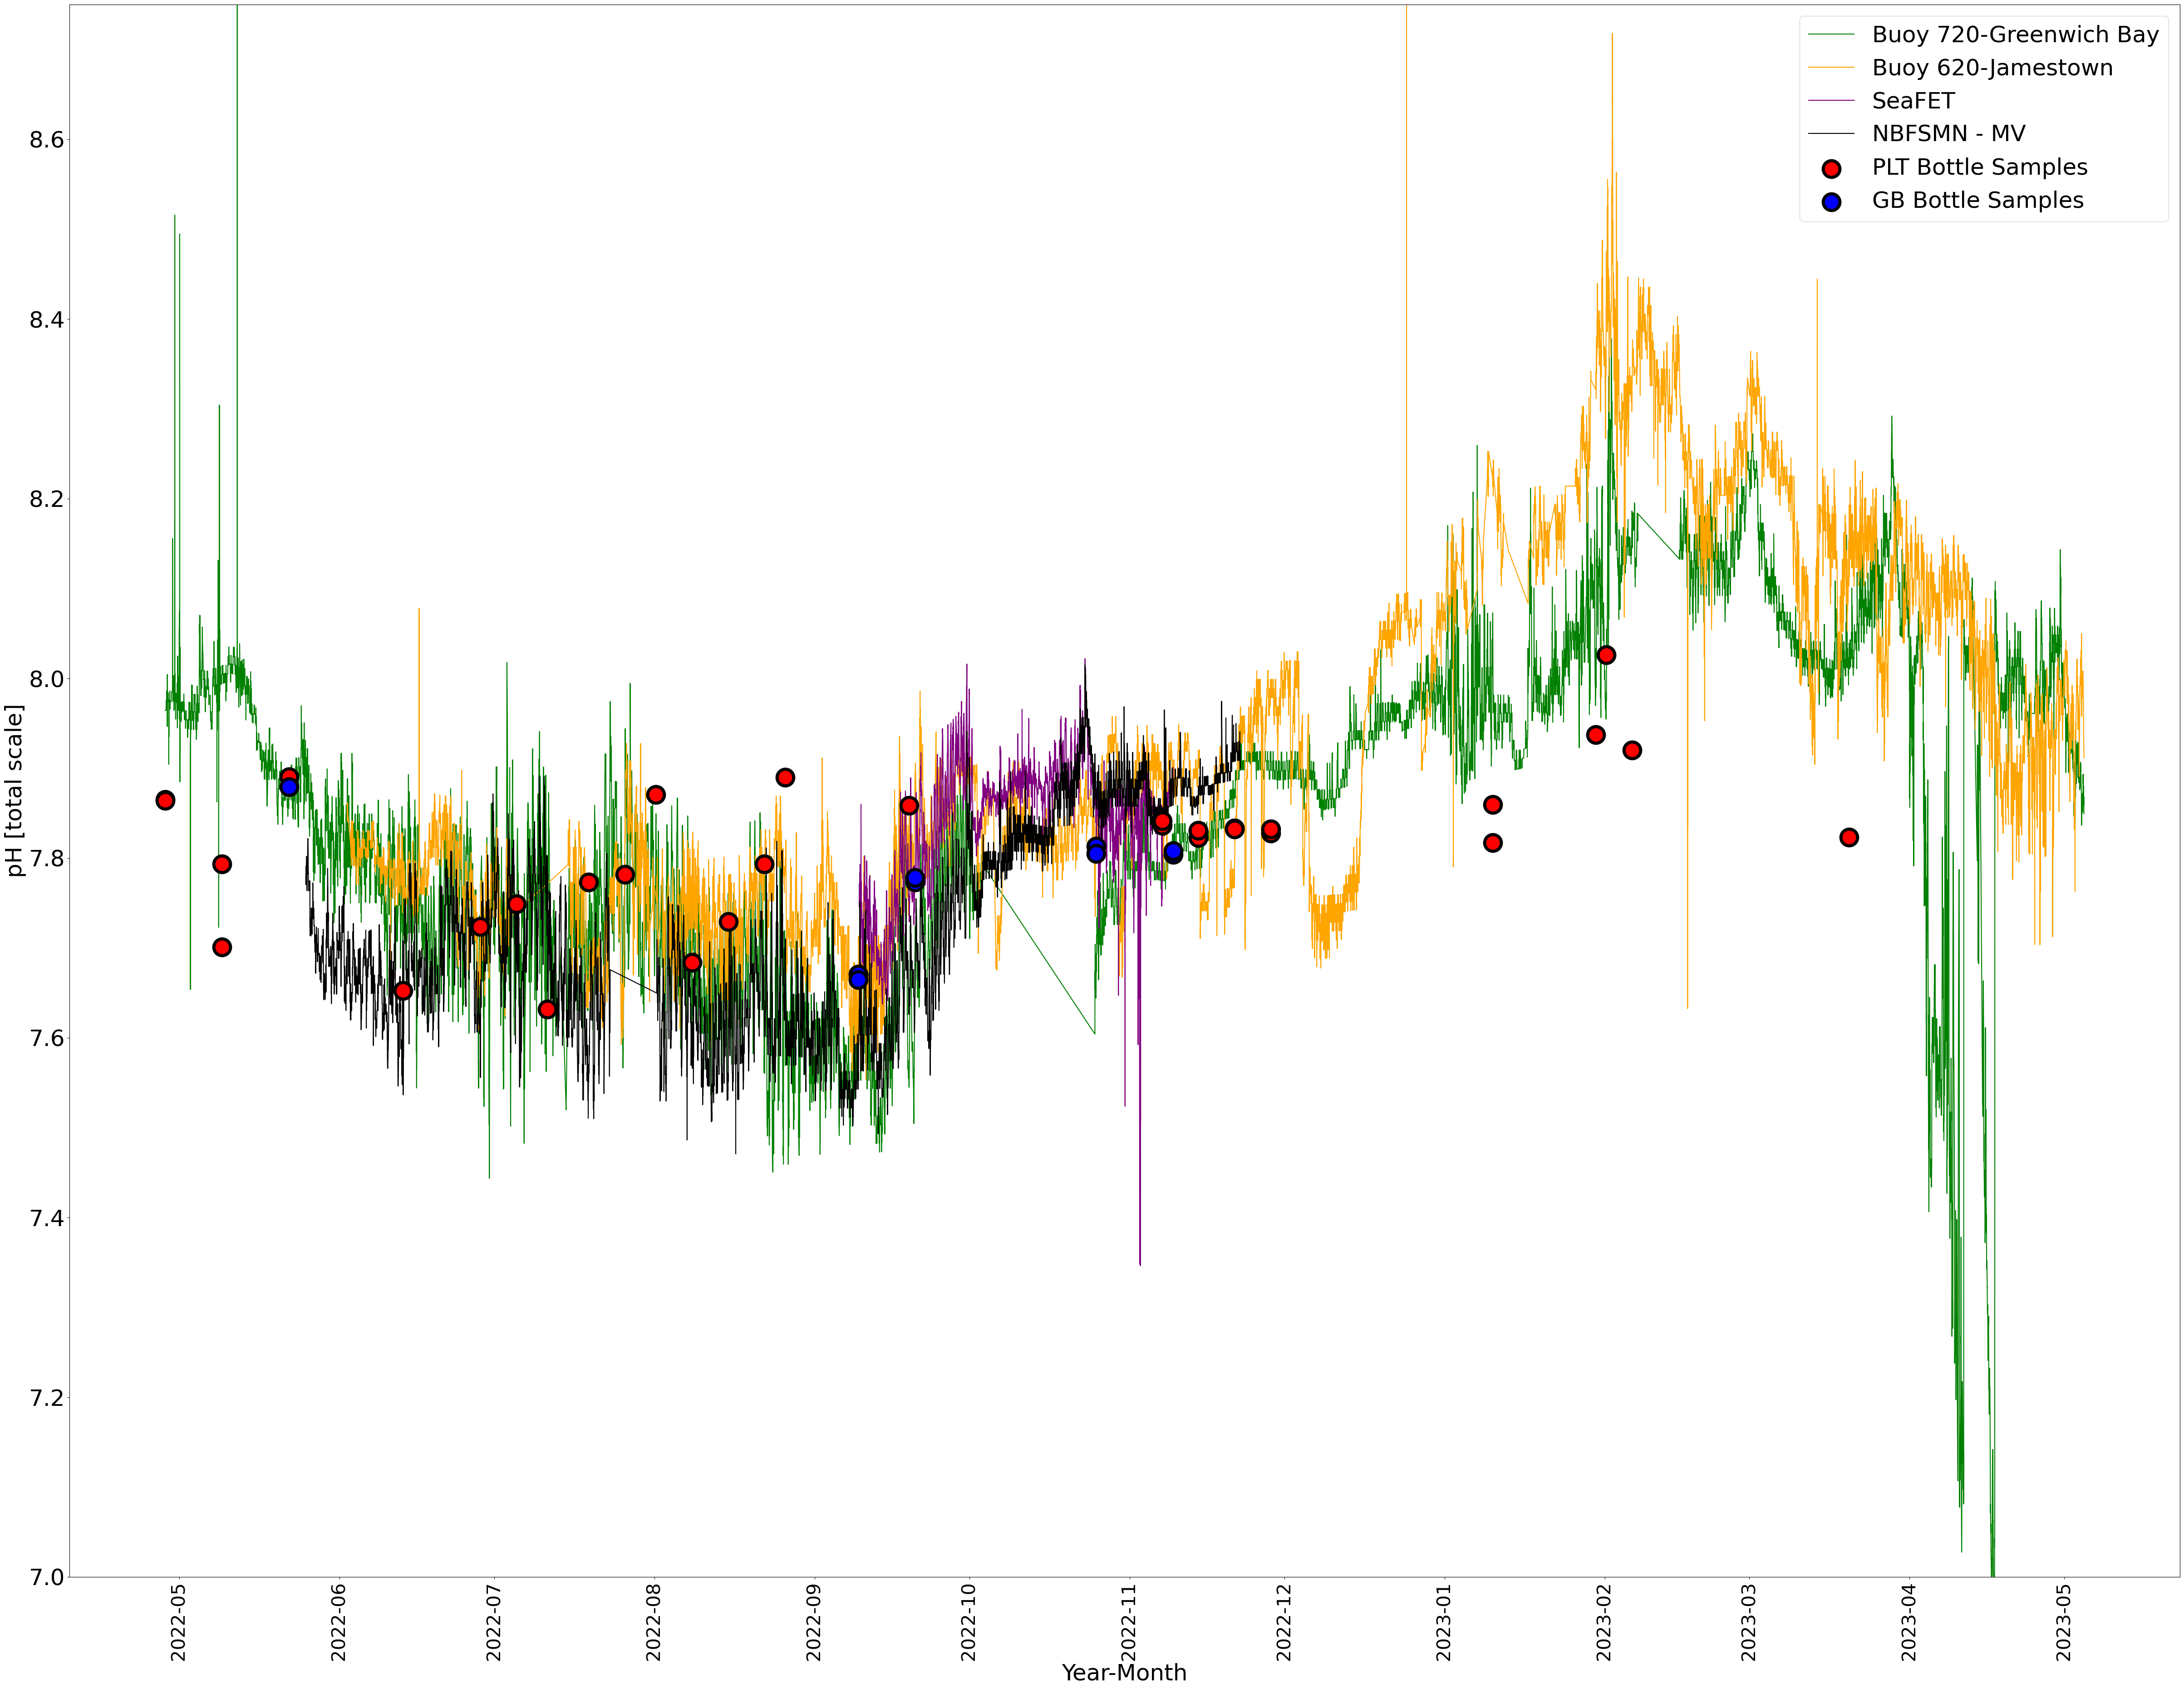

In [56]:
# truncate data to all be later than first lab sample
df720_trunk = df720.where(df720['DateTime'] >= PLT['DateTime'].min()).dropna()
df620_trunk = df620.where(df620['DateTime'] >= PLT['DateTime'].min()).dropna()
NBFSM_trunk = NBFSM.where(NBFSM['DateTime'] >= PLT['DateTime'].min()).dropna()

# declare plot
fig,ax = plt.subplots(figsize=[60,45])
# Hydrocat 720 ph total
ax.plot(df720_trunk['DateTime'], df720_trunk['pH total'], color = 'green', label = 'Buoy 720-Greenwich Bay')
# Hydrocat 620 ph total
ax.plot(df620_trunk['DateTime'], df620_trunk['pH total'], color = 'orange', label = 'Buoy 620-Jamestown')
# SeaFET
ax.plot(pH_data['DateTime'], pH_data['External pH (pH)'], color = 'purple', label = 'SeaFET')
# NBFSM ph total
ax.plot(NBFSM_trunk['DateTime'], NBFSM_trunk['pH total'], color = 'black', label = 'NBFSMN - MV')

ax.scatter(PLT['DateTime'], PLT['pH'], color = 'red', edgecolor = 'black',linewidths = 5,s = 700, label = 'PLT Bottle Samples', zorder = 3)
ax.scatter(GB['DateTime'], GB['pH'], color = 'blue', edgecolor = 'black',linewidths = 5,s = 700, label = 'GB Bottle Samples', zorder = 3)

ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
# ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%Y'))

# ax.xaxis.set_major_locator(mdates.DayLocator(interval=3000))
ax.tick_params('x',labelsize = 30, labelrotation = 90)
ax.tick_params('y',labelsize = 36)
ax.legend(fontsize = 36)
ax.set_xlabel('Year-Month', fontsize = 36)
ax.set_ylabel('pH [total scale]', fontsize = 36)
ax.set_ylim([7,8.75])

fig.savefig('/Users/akbaskind/Documents/Python Scripts/phyto/prelim_pH_literallyeverything_trunk.png', bbox_inches='tight')


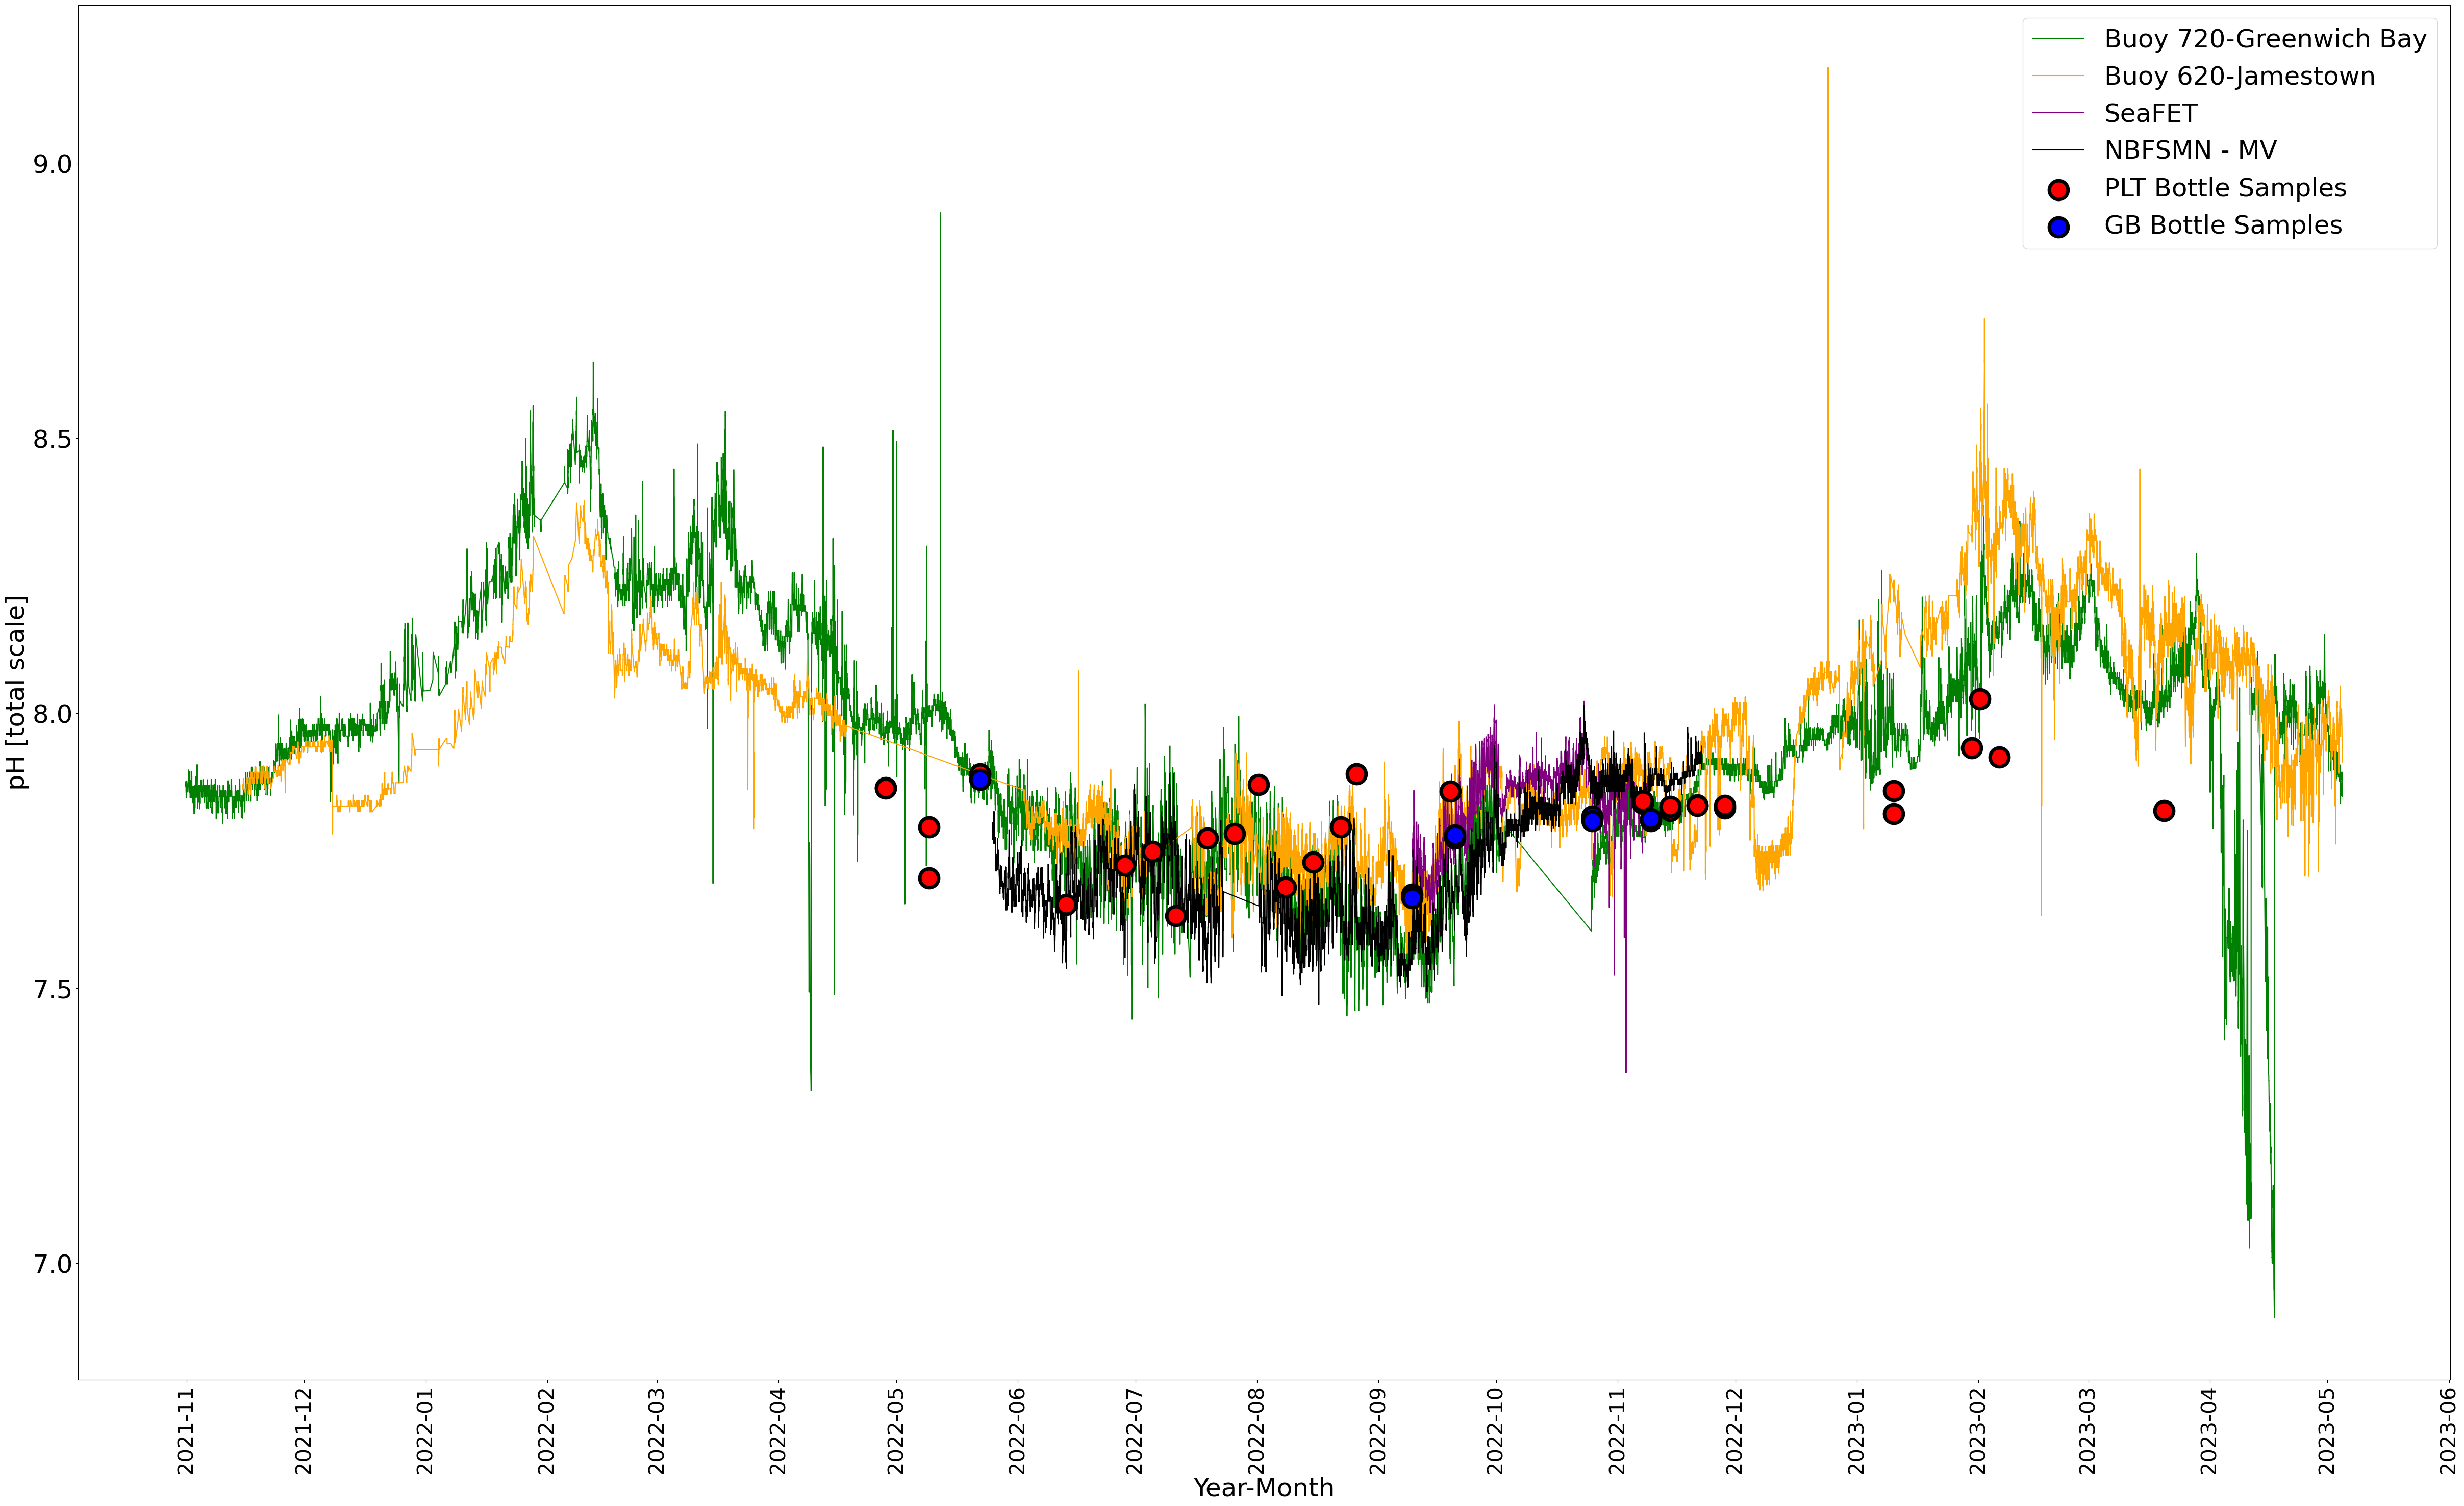

In [57]:

# declare plot
fig,ax = plt.subplots(figsize=[60,35])
# Hydrocat 720 ph total
ax.plot(df720['DateTime'], df720['pH total'], color = 'green', label = 'Buoy 720-Greenwich Bay')
# Hydrocat 620 ph total
ax.plot(df620['DateTime'], df620['pH total'], color = 'orange', label = 'Buoy 620-Jamestown')
# SeaFET
ax.plot(pH_data['DateTime'], pH_data['External pH (pH)'], color = 'purple', label = 'SeaFET')
# NBFSM ph total
ax.plot(NBFSM['DateTime'], NBFSM['pH total'], color = 'black', label = 'NBFSMN - MV')

ax.scatter(PLT['DateTime'], PLT['pH'], color = 'red', edgecolor = 'black',linewidths = 5,s = 700, label = 'PLT Bottle Samples', zorder = 3)
ax.scatter(GB['DateTime'], GB['pH'], color = 'blue', edgecolor = 'black',linewidths = 5,s = 700, label = 'GB Bottle Samples', zorder = 3)

ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
# ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%Y'))

# ax.xaxis.set_major_locator(mdates.DayLocator(interval=3000))
ax.tick_params('x',labelsize = 30, labelrotation = 90)
ax.tick_params('y',labelsize = 36)
ax.legend(fontsize = 36)
ax.set_xlabel('Year-Month', fontsize = 36)
ax.set_ylabel('pH [total scale]', fontsize = 36)
# ax.set_ylim([7,8.75])

fig.savefig('/Users/akbaskind/Documents/Python Scripts/phyto/prelim_pH_literallyeverything.png', bbox_inches='tight')


In [52]:
PLT['DateTime'].min()

Timestamp('2022-04-28 07:30:00')